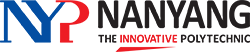

# IT2311 Assignment - Task 1a: Data Preparation

For this task, you are required to perform data understanding to examine your dataset and data cleaning to prepare the data for task 2 and 3.

Rename **DataPreparationStarter.ipynb** to **\<AdminNo\>_DataPreparation.ipynb** and complete the following sub-tasks:

Complete the following sub-tasks:

1. **Load Data**: Load your dataset
2. **Data Understanding**: Examine your dataset
3. **Data Cleaning**: Clean your data and perform all necessary pre-processing tasks
4. **Save Data**: Save the cleaned data for next task

For each sub-task, perform the necessary steps and **explain the rationale taken for each step in this Jupyter notebook**. 

**Done by: Clifton Chen Yi, 231220B**

## Import Libraries and Download Packages

**Rationale:** We import libraries needed for data loading (`pandas`, `json`), text processing (`re`, `nltk`), visualization (`matplotlib`, `seaborn`, `wordcloud`), and general utilities. NLTK resources (tokenizer, stopwords, lemmatizer) are downloaded for NLP preprocessing required in Topic Modelling.

In [ ]:
# Install required packages that are not part of the standard library
!pip install -q wordcloud

In [ ]:
import pandas as pd
import numpy as np
import json
import re
import warnings
warnings.filterwarnings('ignore')

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

print('All libraries imported and NLTK data downloaded successfully.')

## 1. Load Data

**Rationale:** The dataset is stored in JSON Lines format (one JSON object per line). We use `pd.read_json()` with `lines=True` to parse it into a DataFrame for easy manipulation.

**Citation:**
> Jordan, Luke S. (2021). *World Bank Project Documents* [Dataset]. Hugging Face.  
> Available at: https://huggingface.co/datasets/lukesjordan/worldbank-project-documents  
> Licensed under MIT +no-false-attribs (MITNFA) License.  
> **Note:** Any modifications or subsets created from this dataset are the work of the author (Clifton Chen Yi, 231220B) and are not endorsed by or affiliated with the original dataset creator or the World Bank.

In [ ]:
# Load the World Bank projects dataset
task1_df_wb = pd.read_json('Task_1_TM_world_bank_projects_subset.json', orient='records', lines=True)
print(f'Dataset loaded successfully with {task1_df_wb.shape[0]} rows and {task1_df_wb.shape[1]} columns.')
task1_df_wb.head()

## 2. Data Understanding

**Rationale:** Before cleaning, we need to thoroughly examine the dataset to understand its structure, quality, and characteristics. This helps us make informed decisions during the cleaning phase and ensures the data is suitable for Topic Modelling.

### 2.1 Basic Structure and Schema

**Rationale:** Understanding the shape, column names, and data types gives us a foundational view of the dataset. This tells us how many documents we have and confirms the expected schema (project_id, document_text, document_type).

In [ ]:
# Dataset shape
print(f'Dataset Shape: {task1_df_wb.shape}')
print(f'Number of records: {task1_df_wb.shape[0]}')
print(f'Number of features: {task1_df_wb.shape[1]}')
print()

# Column names and data types
print('Column Information:')
print(task1_df_wb.dtypes)
print()

# Detailed info
task1_df_wb.info()

### 2.2 Sample Records

**Rationale:** Inspecting the first and last rows gives us a sense of the data content. We can see the format of project IDs, the nature of the document text, and the document types present.

In [ ]:
# First 5 rows
print('=== First 5 Records ===')
display(task1_df_wb.head())

# Last 5 rows
print('\n=== Last 5 Records ===')
display(task1_df_wb.tail())

### 2.3 Missing Values Analysis

**Rationale:** Missing values in `document_text` would make records useless for Topic Modelling. Missing `project_id` or `document_type` values reduce metadata quality. Identifying missing data helps us decide on imputation or removal strategies.

In [ ]:
# Count missing values
missing_counts = task1_df_wb.isnull().sum()
missing_pct = (task1_df_wb.isnull().sum() / len(task1_df_wb) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing_counts, 'Missing %': missing_pct})
print('Missing Values Summary:')
display(missing_df)

# Also check for empty strings in document_text (not captured by isnull)
empty_text_count = (task1_df_wb['document_text'].astype(str).str.strip() == '').sum()
none_text_count = task1_df_wb['document_text'].isna().sum()
print(f'\nEmpty string document_text records: {empty_text_count}')
print(f'None/NaN document_text records: {none_text_count}')
print(f'Total unusable document_text records: {empty_text_count + none_text_count}')

### 2.4 Duplicate Records Analysis

**Rationale:** Duplicate documents would bias topic modelling results by giving disproportionate weight to certain content. We check for exact duplicates across all columns and also for duplicate document texts specifically.

In [ ]:
# Exact duplicates (all columns)
exact_dupes = task1_df_wb.duplicated().sum()
print(f'Exact duplicate rows (all columns): {exact_dupes}')

# Duplicate document_text values
text_dupes = task1_df_wb['document_text'].duplicated().sum()
print(f'Duplicate document_text values: {text_dupes}')

# Duplicate project_id values (a project can have multiple documents)
pid_dupes = task1_df_wb['project_id'].duplicated().sum()
print(f'Duplicate project_id values: {pid_dupes}')
print(f'Unique project IDs: {task1_df_wb["project_id"].nunique()}')

# Show duplicate rows if any
if exact_dupes > 0:
    print('\nDuplicate rows:')
    display(task1_df_wb[task1_df_wb.duplicated(keep=False)].sort_values('project_id'))

### 2.5 Document Type Distribution

**Rationale:** Understanding the balance between APPROVAL and REVIEW documents is important because different document types may have different writing styles and vocabularies. This affects topic modelling results and interpretation.

In [ ]:
# Document type value counts
doc_type_counts = task1_df_wb['document_type'].value_counts()
doc_type_pct = task1_df_wb['document_type'].value_counts(normalize=True) * 100

print('Document Type Distribution:')
for dtype in doc_type_counts.index:
    print(f'  {dtype}: {doc_type_counts[dtype]} ({doc_type_pct[dtype]:.1f}%)')

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart
sns.countplot(data=task1_df_wb, x='document_type', ax=axes[0], palette='viridis')
axes[0].set_title('Document Type Distribution')
axes[0].set_xlabel('Document Type')
axes[0].set_ylabel('Count')
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width()/2., p.get_height()),
                     ha='center', va='bottom')

# Pie chart
axes[1].pie(doc_type_counts.values, labels=doc_type_counts.index, autopct='%1.1f%%',
            colors=sns.color_palette('viridis', len(doc_type_counts)))
axes[1].set_title('Document Type Proportion')

plt.tight_layout()
plt.show()

### 2.6 Text Length Analysis

**Rationale:** Document length is crucial for topic modelling. Very short documents may not have enough content for meaningful topic extraction, while extremely long documents might dominate the model. Understanding the distribution of text lengths helps us decide on filtering thresholds.

In [ ]:
# Calculate text lengths (character count and word count)
# Filter out None/NaN first for this analysis
valid_text_mask = task1_df_wb['document_text'].notna() & (task1_df_wb['document_text'].astype(str).str.strip() != '')
df_valid = task1_df_wb[valid_text_mask].copy()

df_valid['char_count'] = df_valid['document_text'].str.len()
df_valid['word_count'] = df_valid['document_text'].str.split().str.len()

print('=== Text Length Statistics (Characters) ===')
print(df_valid['char_count'].describe().round(1))
print()
print('=== Text Length Statistics (Words) ===')
print(df_valid['word_count'].describe().round(1))

# Distribution plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df_valid['char_count'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Document Length (Characters)')
axes[0].set_xlabel('Character Count')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df_valid['char_count'].median(), color='red', linestyle='--', label=f'Median: {df_valid["char_count"].median():.0f}')
axes[0].legend()

axes[1].hist(df_valid['word_count'], bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribution of Document Length (Words)')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].axvline(df_valid['word_count'].median(), color='red', linestyle='--', label=f'Median: {df_valid["word_count"].median():.0f}')
axes[1].legend()

plt.tight_layout()
plt.show()

### 2.7 Text Length by Document Type

**Rationale:** Comparing text lengths across document types reveals whether APPROVAL and REVIEW documents differ in verbosity. This is an interesting discovery that can inform our understanding of the corpus and the topics we may extract.

In [ ]:
# Box plot comparing word count by document type
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=df_valid, x='document_type', y='word_count', palette='Set2', ax=ax)
ax.set_title('Word Count Distribution by Document Type')
ax.set_xlabel('Document Type')
ax.set_ylabel('Word Count')
plt.tight_layout()
plt.show()

# Summary statistics by document type
print('Word Count Statistics by Document Type:')
display(df_valid.groupby('document_type')['word_count'].describe().round(1))

### 2.8 Unique Values and Project ID Analysis

**Rationale:** Examining unique project IDs and their occurrence helps us understand the data granularity. Some projects may have multiple documents (both APPROVAL and REVIEW), which is expected and valid.

In [ ]:
# Unique values per column
print('Unique Values:')
for col in task1_df_wb.columns:
    print(f'  {col}: {task1_df_wb[col].nunique()} unique values')

# Projects with multiple documents
docs_per_project = task1_df_wb.groupby('project_id').size()
multi_doc_projects = docs_per_project[docs_per_project > 1]
print(f'\nProjects with multiple documents: {len(multi_doc_projects)}')
if len(multi_doc_projects) > 0:
    print('\nProjects with multiple documents:')
    for pid, count in multi_doc_projects.items():
        types = task1_df_wb[task1_df_wb['project_id'] == pid]['document_type'].tolist()
        print(f'  {pid}: {count} documents - Types: {types}')

### 2.9 Data Quality Summary and Key Discoveries

**Key Discoveries from Data Understanding:**

1. **Missing/Empty Text:** Some records have missing (`None`/`NaN`) or empty document text. These are unusable for topic modelling and must be removed.
2. **Duplicate Records:** There are exact duplicate rows that would bias the topic model. These need to be removed.
3. **Document Type Balance:** The dataset contains both APPROVAL and REVIEW documents. Understanding this split helps interpret topic modelling results.
4. **Text Length Variation:** Documents vary significantly in length. Very short documents may lack sufficient content for meaningful topic extraction.
5. **Text Noise:** Document text contains newline characters (`\n`), extra whitespace, special characters, URLs, email addresses, and HTML artifacts from OCR scanning that need to be cleaned.
6. **Project ID Format:** All project IDs follow the pattern `P` followed by digits, which is consistent with World Bank conventions.

## 3. Data Cleaning

**Rationale:** Data cleaning prepares the text for Topic Modelling (e.g., LDA). Raw text contains noise that would degrade model quality. Our cleaning pipeline addresses:
- Removing unusable records (missing/empty text, duplicates)
- Text normalization (lowercase, remove special characters)
- Tokenization (splitting text into words)
- Stopword removal (removing common words with no topical meaning)
- Lemmatization (reducing words to their base form)

We create a working copy to preserve the original data.

### 3.1 Remove Records with Missing or Empty Document Text

**Rationale:** Records without document text cannot contribute to topic modelling. We remove rows where `document_text` is `None`, `NaN`, or an empty/whitespace-only string. These records have no informational value for our analysis.

In [ ]:
# Create working copy
df_clean = task1_df_wb.copy()
initial_count = len(df_clean)

# Remove rows with None/NaN document_text
df_clean = df_clean.dropna(subset=['document_text'])
after_na = len(df_clean)
print(f'Removed {initial_count - after_na} rows with NaN/None document_text')

# Remove rows with empty or whitespace-only document_text
df_clean = df_clean[df_clean['document_text'].str.strip() != '']
after_empty = len(df_clean)
print(f'Removed {after_na - after_empty} rows with empty/whitespace-only document_text')

print(f'\nRecords remaining: {len(df_clean)} (removed {initial_count - len(df_clean)} total)')

### 3.2 Remove Duplicate Records

**Rationale:** Exact duplicate records (same project_id, document_text, and document_type) would bias topic modelling by over-representing certain content. We keep the first occurrence and remove subsequent duplicates.

In [ ]:
before_dedup = len(df_clean)
df_clean = df_clean.drop_duplicates(keep='first')
after_dedup = len(df_clean)
print(f'Removed {before_dedup - after_dedup} exact duplicate rows')
print(f'Records remaining: {len(df_clean)}')

### 3.3 Text Normalization and Cleaning

**Rationale:** Raw document text contains noise that would reduce topic modelling quality:
- **Newline characters (`\n`)**: Artifacts from document formatting; replaced with spaces.
- **URLs and email addresses**: Not meaningful for topic extraction; removed.
- **HTML tags**: OCR scanning artifacts; removed.
- **Special characters and punctuation**: Not useful for topic modelling; removed.
- **Numbers**: Standalone numbers (dates, IDs, amounts) add noise; removed.
- **Extra whitespace**: Collapsed to single spaces for consistency.
- **Case normalization**: Converted to lowercase so 'Project' and 'project' are treated as the same word.

In [ ]:
def clean_text(text):
    """Clean and normalize document text for topic modelling."""
    if not isinstance(text, str):
        return ''
    
    # Replace newline characters with spaces
    text = text.replace('\n', ' ')
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+\.\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and punctuation, keep only letters and spaces
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply text cleaning
df_clean['cleaned_text'] = df_clean['document_text'].apply(clean_text)

# Show before and after for first record
print('=== Example: Before Cleaning ===')
print(df_clean['document_text'].iloc[0][:200])
print('\n=== Example: After Cleaning ===')
print(df_clean['cleaned_text'].iloc[0][:200])

### 3.4 Tokenization

**Rationale:** Tokenization splits the cleaned text into individual words (tokens). This is a prerequisite for stopword removal and lemmatization. We use NLTK's `word_tokenize` which handles edge cases better than simple whitespace splitting.

In [ ]:
# Tokenize the cleaned text
df_clean['tokens'] = df_clean['cleaned_text'].apply(word_tokenize)

# Show example
print('Example tokens (first 20):')
print(df_clean['tokens'].iloc[0][:20])
print(f'\nTotal tokens in first document: {len(df_clean["tokens"].iloc[0])}')

### 3.5 Stopword Removal

**Rationale:** Stopwords (e.g., 'the', 'is', 'and') are common words that carry little topical meaning. Removing them helps topic models focus on words that are more indicative of document topics. We use NLTK's English stopword list and add domain-specific stopwords commonly found in World Bank documents (e.g., 'document', 'world', 'bank', 'project') that appear in almost every document and would not help differentiate topics. We also remove very short words (< 3 characters) that are typically not meaningful.

In [ ]:
# Define stopwords
stop_words = set(stopwords.words('english'))

# Add domain-specific stopwords that appear in almost every World Bank document
domain_stopwords = {
    'world', 'bank', 'project', 'document', 'report', 'official',
    'use', 'file', 'copy', 'page', 'also', 'would', 'may', 'one',
    'two', 'three', 'four', 'five', 'new', 'first', 'second'
}
stop_words.update(domain_stopwords)

def remove_stopwords(tokens):
    """Remove stopwords and very short words from token list."""
    return [t for t in tokens if t not in stop_words and len(t) >= 3]

df_clean['tokens_no_stop'] = df_clean['tokens'].apply(remove_stopwords)

# Show reduction
orig_len = df_clean['tokens'].apply(len).sum()
new_len = df_clean['tokens_no_stop'].apply(len).sum()
print(f'Tokens before stopword removal: {orig_len}')
print(f'Tokens after stopword removal: {new_len}')
print(f'Reduction: {orig_len - new_len} tokens ({(orig_len - new_len)/orig_len*100:.1f}%)')

print('\nExample tokens after stopword removal (first 20):')
print(df_clean['tokens_no_stop'].iloc[0][:20])

### 3.6 Lemmatization

**Rationale:** Lemmatization reduces words to their base/dictionary form (e.g., 'communities' → 'community', 'improved' → 'improved'). This is preferred over stemming for topic modelling because lemmatized words are actual words that are more interpretable in topic labels. It also reduces vocabulary size, making the topic model more efficient.

In [ ]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    """Lemmatize tokens using WordNet lemmatizer."""
    return [lemmatizer.lemmatize(token) for token in tokens]

df_clean['tokens_lemmatized'] = df_clean['tokens_no_stop'].apply(lemmatize_tokens)

# Show example of lemmatization effect
print('Lemmatization Examples:')
for orig, lemma in zip(df_clean['tokens_no_stop'].iloc[0][:15], df_clean['tokens_lemmatized'].iloc[0][:15]):
    if orig != lemma:
        print(f'  {orig} → {lemma}')

print('\nLemmatized tokens (first 20):')
print(df_clean['tokens_lemmatized'].iloc[0][:20])

### 3.7 Reconstruct Final Cleaned Text

**Rationale:** After tokenization, stopword removal, and lemmatization, we rejoin tokens into a single string. This final cleaned text is what will be used for Topic Modelling. We also filter out any documents that became too short after cleaning (fewer than 10 words), as they would not contribute meaningful topics.

In [ ]:
# Rejoin tokens into cleaned text
df_clean['final_cleaned_text'] = df_clean['tokens_lemmatized'].apply(lambda x: ' '.join(x))

# Remove documents that are too short after cleaning
min_word_threshold = 10
before_filter = len(df_clean)
df_clean['final_word_count'] = df_clean['tokens_lemmatized'].apply(len)
df_clean = df_clean[df_clean['final_word_count'] >= min_word_threshold]
after_filter = len(df_clean)
print(f'Removed {before_filter - after_filter} documents with fewer than {min_word_threshold} words after cleaning')
print(f'\nFinal dataset size: {len(df_clean)} documents')

# Show example
print('\n=== Example: Final Cleaned Text ===')
print(df_clean['final_cleaned_text'].iloc[0][:300])

### 3.8 Post-Cleaning Verification

**Rationale:** We verify the quality of our cleaned data by checking the final statistics and visualizing the most common words. This confirms our cleaning pipeline is working correctly and the data is ready for topic modelling.

In [ ]:
# Summary statistics of cleaned data
print('=== Cleaned Dataset Summary ===')
print(f'Total documents: {len(df_clean)}')
print(f'Document types: {df_clean["document_type"].value_counts().to_dict()}')
print(f'\nFinal word count statistics:')
print(df_clean['final_word_count'].describe().round(1))

# No remaining missing values
print(f'\nRemaining null values in final_cleaned_text: {df_clean["final_cleaned_text"].isna().sum()}')
print(f'Remaining empty strings in final_cleaned_text: {(df_clean["final_cleaned_text"] == "").sum()}')

In [ ]:
# Most common words across all documents
from collections import Counter

all_tokens = [token for tokens in df_clean['tokens_lemmatized'] for token in tokens]
word_freq = Counter(all_tokens)
top_words = word_freq.most_common(20)

print('Top 20 Most Common Words After Cleaning:')
for word, count in top_words:
    print(f'  {word}: {count}')

# Bar chart of top words
fig, ax = plt.subplots(figsize=(12, 5))
words, counts = zip(*top_words)
ax.barh(range(len(words)), counts, color='steelblue')
ax.set_yticks(range(len(words)))
ax.set_yticklabels(words)
ax.invert_yaxis()
ax.set_xlabel('Frequency')
ax.set_title('Top 20 Most Common Words After Cleaning')
plt.tight_layout()
plt.show()

In [ ]:
# Word Cloud visualization
all_text = ' '.join(df_clean['final_cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      max_words=100, colormap='viridis').generate(all_text)

fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
ax.set_title('Word Cloud of Cleaned Document Text', fontsize=14)
plt.tight_layout()
plt.show()

### 3.9 Data Cleaning Summary

**Summary of all cleaning and transformation steps performed:**

| Step | Action | Rationale |
|------|--------|-----------|
| 1 | Remove rows with missing/empty `document_text` | Records without text are unusable for topic modelling |
| 2 | Remove exact duplicate rows | Duplicates would bias topic model results |
| 3 | Replace newline characters with spaces | Format artifacts from document structure |
| 4 | Remove URLs and email addresses | Not meaningful for topic extraction |
| 5 | Remove HTML tags | OCR scanning artifacts |
| 6 | Convert to lowercase | Normalize case for consistent word matching |
| 7 | Remove special characters and numbers | Punctuation and numbers add noise |
| 8 | Collapse extra whitespace | Normalize spacing |
| 9 | Tokenize text | Split text into individual words for processing |
| 10 | Remove stopwords (English + domain-specific) | Common words do not help differentiate topics |
| 11 | Remove short words (< 3 chars) | Very short words are typically not meaningful |
| 12 | Lemmatize tokens | Reduce words to base form for better topic coherence |
| 13 | Filter short documents (< 10 words) | Too short for meaningful topic extraction |

## 4. Save Data

**Rationale:** We save the cleaned dataset in CSV format for use in the next task (Topic Modelling). We save only the columns needed: `project_id`, `document_type`, and `final_cleaned_text`. The CSV format is chosen for portability and ease of loading in the next notebook.

In [ ]:
# Select columns to save
df_to_save = df_clean[['project_id', 'document_type', 'final_cleaned_text']].copy()
df_to_save = df_to_save.rename(columns={'final_cleaned_text': 'cleaned_text'})

# Save to CSV
output_file = 'Task_1_cleaned_data.csv'
df_to_save.to_csv(output_file, index=False)
print(f'Cleaned data saved to: {output_file}')
print(f'Shape: {df_to_save.shape}')
print(f'\nPreview of saved data:')
display(df_to_save.head())

In [ ]:
# Verify saved file can be loaded correctly
df_verify = pd.read_csv(output_file)
print(f'Verification - Loaded {len(df_verify)} records from {output_file}')
print(f'Columns: {list(df_verify.columns)}')
print(f'Missing values: {df_verify.isnull().sum().sum()}')
print('\nData is ready for Topic Modelling in Task 1b.')

## Submission
Export your completed work as HTML. Select **File** > **Download as** > **HTML (.html)**.